# CNN for MNIST using PyTorch

This notebook demonstrates how to train a Convolutional Neural Network (CNN) on the MNIST dataset using PyTorch. It includes loading and normalizing the dataset, defining the CNN model, training the model, evaluating it, and visualizing the results.

## Import Libraries

We need to import several libraries to handle data, build and train the neural network, and visualize the results. We will use PyTorch for the deep learning components, torchvision for handling the dataset, and matplotlib for plotting.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

## Load and Normalize the MNIST Dataset

We will load the MNIST dataset, which consists of handwritten digit images. We use torchvision to download the dataset and apply transformations to normalize the images.

In [2]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = tuple(range(10))


## Define the CNN Model

We will define a simple Convolutional Neural Network (CNN) for classifying the MNIST digits. The network consists of two convolutional layers followed by two fully connected layers. Dropout layers are added to prevent overfitting.


### Explanation of the Network Architecture:

- **First Convolutional Layer**:
  - Input channels: 1 (grayscale images)
  - Output channels: 4 (feature maps)
  - Kernel size: 3x3
  - Stride: 1 (default)
  - Padding: 0 (default)
  
  The output size after this layer is calculated as:
  $$
  \text{Output size} = \frac{(\text{Input size} - \text{Kernel size})}{\text{Stride}} + 1 = \frac{(28 - 3)}{1} + 1 = 26 \times 26
  $$

- **Second Convolutional Layer**:
  - Input channels: 4 (from the previous conv layer)
  - Output channels: 8 (feature maps)
  - Kernel size: 3x3
  - Stride: 1 (default)
  - Padding: 0 (default)
  
  The output size after this layer is calculated as:
  $$
  \text{Output size} = \frac{(26 - 3)}{1} + 1 = 24 \times 24
  $$

- **Max Pooling Layer**:
  - Kernel size: 2x2
  - Stride: 2 (default)
  - Reduces the spatial dimensions by a factor of 2.
  
  The output size after this layer is calculated as:
  $$
  \text{Output size} = \frac{24}{2} = 12 \times 12
  $$

- **First Fully Connected Layer**:
  - Input features: 8 * 12 * 12 (after conv layers and max pooling)
  - Output features: 32

- **Second Fully Connected Layer**:
  - Input features: 32 (from the previous fc layer)
  - Output features: 10 (number of classes)

- **Dropout Layers**:
  - Dropout1: Dropout rate of 0.25
  - Dropout2: Dropout rate of 0.5

The input features for the first fully connected layer are calculated based on the dimensions of the output from the convolutional and pooling layers. This ensures the fully connected layer has the correct number of inputs.


In [3]:
class Net(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for classifying MNIST digits.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 4 , kernel_size = 3 , stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 4 , out_channels = 8 , kernel_size = 3 , stride = 1)
        
        self.fc1 = nn.Linear(12 * 12 * 8 , 32)
        self.fc2 = nn.Linear(32 , 10)

    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters:
        x (Tensor): Input image tensor.
        
        Returns:
        Tensor: Output tensor with class scores(softmax).
        """

        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)

        # flattern
        
        x = torch.flatten(x , 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        # output = nn.Softmax(x)
        output = nn.LogSoftmax(dim = 1)(x)

        return output

# Instantiate the network
net = Net()

## Define a Loss Function and Optimizer

We will use Cross Entropy Loss as our loss function, which is suitable for multi-class classification problems. The optimizer used is Adam, which is an adaptive learning rate optimization algorithm.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters() , lr = 0.001)

## Train the Network

We define a function to train the network. The function iterates over the training data multiple times (epochs), and in each epoch, it performs forward propagation, calculates the loss, performs backward propagation, and updates the network weights. We also evaluate the network on the test data at the end of each epoch.

In [5]:
def train_model(net, trainloader, testloader, criterion, optimizer, epochs=10):
    """
    Train the given neural network model.
    
    Parameters:
    net (nn.Module): The neural network model to train.
    trainloader (DataLoader): The DataLoader for the training data.
    testloader (DataLoader): The DataLoader for the testing data.
    criterion (nn.Module): The loss function.
    optimizer (optim.Optimizer): The optimizer for training.
    epochs (int): Number of epochs to train the model. Default is 10.
    
    Returns:
    tuple: (train_losses, test_losses) lists of training and testing losses per epoch.
    """

    train_losses , test_losses = [] , []
    for epoch in range(epochs) :
        net.train() # set the network to training mode
        running_loss = 0.

        for images , labels in trainloader :
            optimizer.zero_grad() # zero the gradient
            outputs = net(images) # forward
            loss = criterion(outputs , labels) # compute the loss
            loss.backward() # back propagation
            optimizer.step() 
            running_loss += loss.item()
        
        train_losses.append(running_loss / len(trainloader))

        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad() :
            for images , labels in testloader : 
                outputs = net(images)
                loss = criterion(outputs , labels)
                test_loss += loss

                _ , predicted = torch.max(outputs.data , 1)
                total = labels.size(0) # return the length of labels

                correct += (predicted == labels).sum().item() # count the correct prediction

        test_losses.append(test_loss / total)
        
        # print the statistics for the current epoch
        print(f"Epoch: {epoch + 1} , train_loss: {train_losses[epoch]} , test_loss: {test_losses[epoch]} , Accuracy: {correct / len(testloader):.2f}%")

 
    return train_losses, test_losses

## Plot Training and Testing Losses

After training the network, we can visualize the training and testing losses over the epochs to understand the training process. A plot of the losses helps to diagnose if the model is overfitting or underfitting.

In [6]:
train_losses,test_losses = train_model(net, trainloader, testloader, criterion, optimizer, epochs=5)

Epoch: 1 , train_loss: 0.38133887049431603 , test_loss: 0.12366793304681778 , Accuracy: 96.30%
Epoch: 2 , train_loss: 0.11264250940643251 , test_loss: 0.09164319187402725 , Accuracy: 97.21%
Epoch: 3 , train_loss: 0.0813852767040953 , test_loss: 0.06491085141897202 , Accuracy: 97.90%
Epoch: 4 , train_loss: 0.06605041576549411 , test_loss: 0.06622736901044846 , Accuracy: 97.80%
Epoch: 5 , train_loss: 0.055609917303469654 , test_loss: 0.04899655282497406 , Accuracy: 98.30%


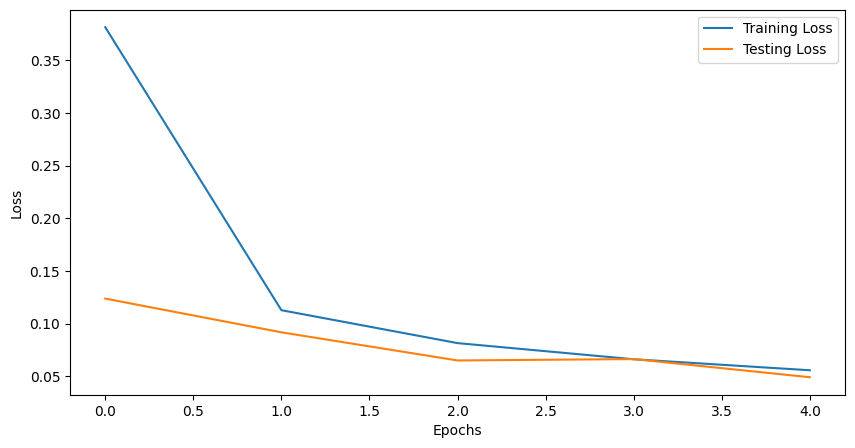

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Confusion Matrix

To evaluate the performance of the model, we can create a confusion matrix. This matrix helps to visualize the performance of the classification model by showing the correct and incorrect predictions.

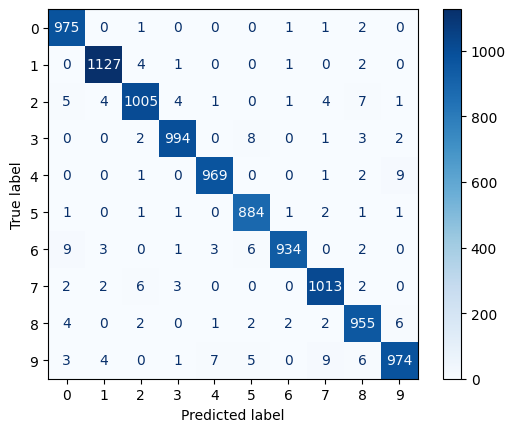

In [8]:
all_preds = torch.tensor([])
all_labels = torch.tensor([])

net.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(cmap=plt.cm.Blues)
plt.show()


## Real-Time Demo

To demonstrate the model's performance, we can visualize some sample predictions. We will display a batch of test images along with their ground truth labels and the predictions made by the model.

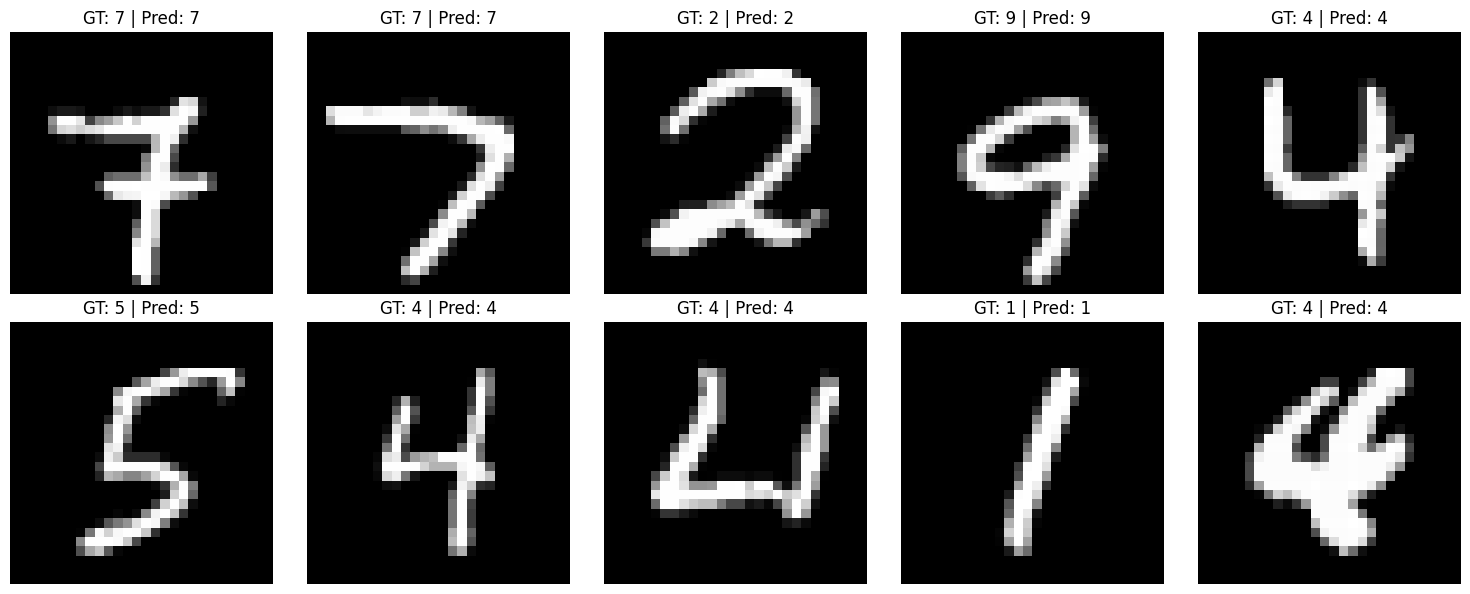

In [9]:
import random
import matplotlib.pyplot as plt

def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.squeeze(npimg), cmap='gray')

# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict labels for the test set
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Randomly select 10 images
indices = random.sample(range(len(images)), 10)

# Create a figure for displaying the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Display each selected image with its ground truth and predicted label
for i, idx in enumerate(indices):
    row, col = divmod(i, 5)
    img = images[idx]
    label = labels[idx].item()
    pred = predicted[idx].item()
    title = f'GT: {classes[label]} | Pred: {classes[pred]}'
    imshow(img, axes[row, col])
    axes[row, col].set_title(title)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
